# tascCODA - Tree-aggregated compositional analysis of high-throughput sequencing data

This notebook is a tutorial on how to use tascCODA [Ostner et al., 2021](https://www.frontiersin.org/articles/10.3389/fgene.2021.766405/full) for tree-aggregated compositional analysis of high-throughput sequencing (HTS) data.

For this example, we use single-cell RNA sequencing data. However, there are no limitations to use tascCODA with other HTS data, such as 16S rRNA sequencing.

The particular dataset for this analysis was generated by [Smillie et al., 2019](https://doi.org/10.1016/j.cell.2019.06.029). It contains samples from two different regions in the small intestine of mice - Epithelium and Lamina Propria - and three different inflammation conditions - healthy, non-inflamed and inflamed. In total, we have 365.492 cells from 51 cell types in 133 samples.

This tutorial is designed to be executed on a standard computer (any operating system) in a Python environment with tascCODA, Jupyter notebook and all their dependencies installed. Running the tutorial takes about 8 minutes on a 2020 Apple MacBook Pro (16GB RAM).

In [1]:
# Setup
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad

import pertpy as pt

import importlib

Installed version 0.4.0 of pertpy is newer than the latest release 0.3.0! You are running a nightly version and 
features may break!

## Data setup

First, we read in the per-cell data. In this dataset, samples are specified as "Subject", and cell types are denoted as "Cluster". Interesting covariates are the samples' location and health status.
The columns "Major_l1" - "Major_l4" and "Cluster" describe a lineage tree over the cell types.

In [2]:
smillie_counts = ad.read_h5ad("data/smillie_data.h5ad")
# smillie_counts.obs["sample_id"] = smillie_counts.obs["Subject"].astype(str) + smillie_counts.obs["Sample"].astype(str)
# print(len(pd.unique(smillie_counts.obs["sample_id"])))
smillie_counts.obs

,NAME,Subject,Sample,Location,Replicate,Health,Cluster,nGene,nUMI,Major_l1,Major_l2,Major_l3,Major_l4
0,N10.EpiA.AAACATACAACCAC,N10,EpiA,Epi,A,Healthy,Enterocyte Progenitors,425,968,Epithelial,Epithelial,Absorptive,Immature cells
1,N10.EpiA.AAACATACAGGCGA,N10,EpiA,Epi,A,Healthy,Cycling TA,1695,7273,Epithelial,Epithelial,Cycling TA3,Cycling TA4
2,N10.EpiA.AAACATACCACTAG,N10,EpiA,Epi,A,Healthy,Immature Goblet,391,1190,Epithelial,Epithelial,Secretory,Progenitor cells
3,N10.EpiA.AAACATACCCTTTA,N10,EpiA,Epi,A,Healthy,Secretory TA,1327,5620,Epithelial,Epithelial,Secretory,Progenitor cells
4,N10.EpiA.AAACATACTGCAAC,N10,EpiA,Epi,A,Healthy,Immature Enterocytes 2,1383,4676,Epithelial,Epithelial,Absorptive,Immature cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...
365487,N9.LPB.TTTATCCTAACGAA,N9,LPB,LP,B,Inflamed,Enterocytes,2768,18811,Epithelial,Epithelial,Absorptive,Absorptive Mature cells
365488,N9.LPB.TTTATCCTGTAAAG,N9,LPB,LP,B,Inflamed,Plasma,1392,27685,Immune,Lymphoid,B cells,Plasma4
365489,N9.LPB.TTTATCCTGTCGTA,N9,LPB,LP,B,Inflamed,Plasma,574,5478,Immune,Lymphoid,B cells,Plasma4
365490,N9.LPB.TTTCAGTGGCGTTA,N9,LPB,LP,B,Inflamed,Macrophages,1437,5698,Immune,Myeloid,Monocytes,Macrophages4


Next, we convert the data to a (samples x cell types) object.
To identify the statistical samples, we need to combine the "Subject" and "Sample" columns.
We also need to extract the tree-structured cell lineage information (Lineages `Major_l1` - `Major_l4`) from the data, generate a Newick string through `tasccoda.tree_utils.df2newick()` and convert it into a [ete3](http://etetoolkit.org/) tree object. This is all done within the `load` function by specifying.

In [3]:
tasccoda_model = pt.tl.Tasccoda()
smillie_data = tasccoda_model.load(smillie_counts, type="cell_level", cell_type_identifier="Cluster", sample_identifier=["Subject", "Sample"], covariate_obs=["Location", "Health"], levels_orig=["Major_l1", "Major_l2", "Major_l3", "Major_l4", "Cluster"], add_level_name=True)
smillie_data

MuData object with n_obs × n_vars = 365625 × 51
  2 modalities
    rna:	365492 x 0
      obs:	'NAME', 'Subject', 'Sample', 'Location', 'Replicate', 'Health', 'Cluster', 'nGene', 'nUMI', 'Major_l1', 'Major_l2', 'Major_l3', 'Major_l4', 'scCODA_sample_id'
    coda:	133 x 51
      obs:	'Location', 'Health', 'Subject', 'Sample'
      var:	'n_cells'
      uns:	'tree'

We can also visualize the tree:

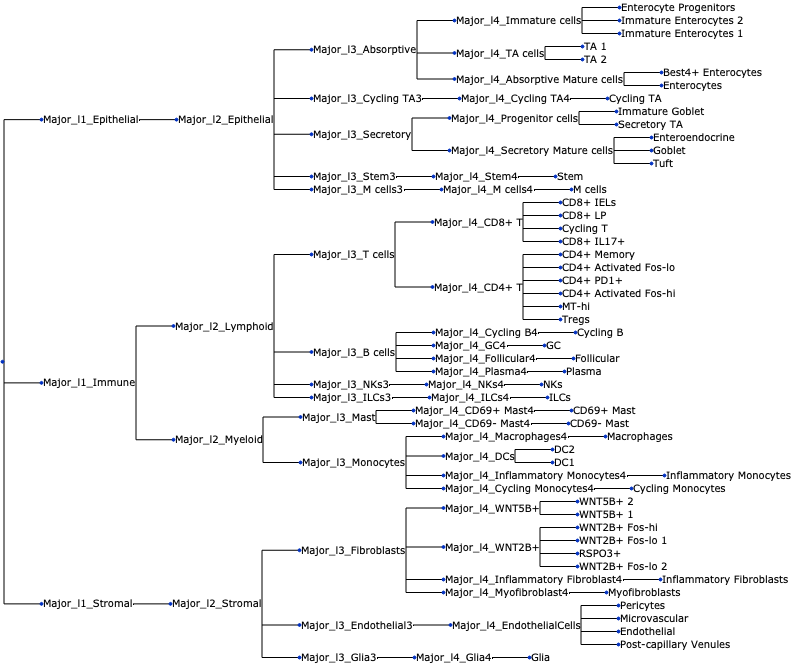

In [4]:
pt.pl.coda.draw_tree(smillie_data["coda"])

For this tutorial, we focus on finding changes between healthy and non-inflamed tissue in the Lamina Propria. Therefore, we subset the data accordingly, and end up with 48 samples:

In [5]:
smillie_data.mod["coda_LP"] = smillie_data["coda"][(smillie_data["coda"].obs["Health"].isin(["Healthy", "Non-inflamed"])) & (smillie_data["coda"].obs["Location"] == "LP")]
smillie_data

MuData object with n_obs × n_vars = 365625 × 51
  3 modalities
    rna:	365492 x 0
      obs:	'NAME', 'Subject', 'Sample', 'Location', 'Replicate', 'Health', 'Cluster', 'nGene', 'nUMI', 'Major_l1', 'Major_l2', 'Major_l3', 'Major_l4', 'scCODA_sample_id'
    coda:	133 x 51
      obs:	'Location', 'Health', 'Subject', 'Sample'
      var:	'n_cells'
      uns:	'tree'
    coda_LP:	48 x 51
      obs:	'Location', 'Health', 'Subject', 'Sample'
      var:	'n_cells'
      uns:	'tree'

A quick plot of the data with the `sccoda.util.data_visualization` module shows us that there are some changes in relative abundance in the data:

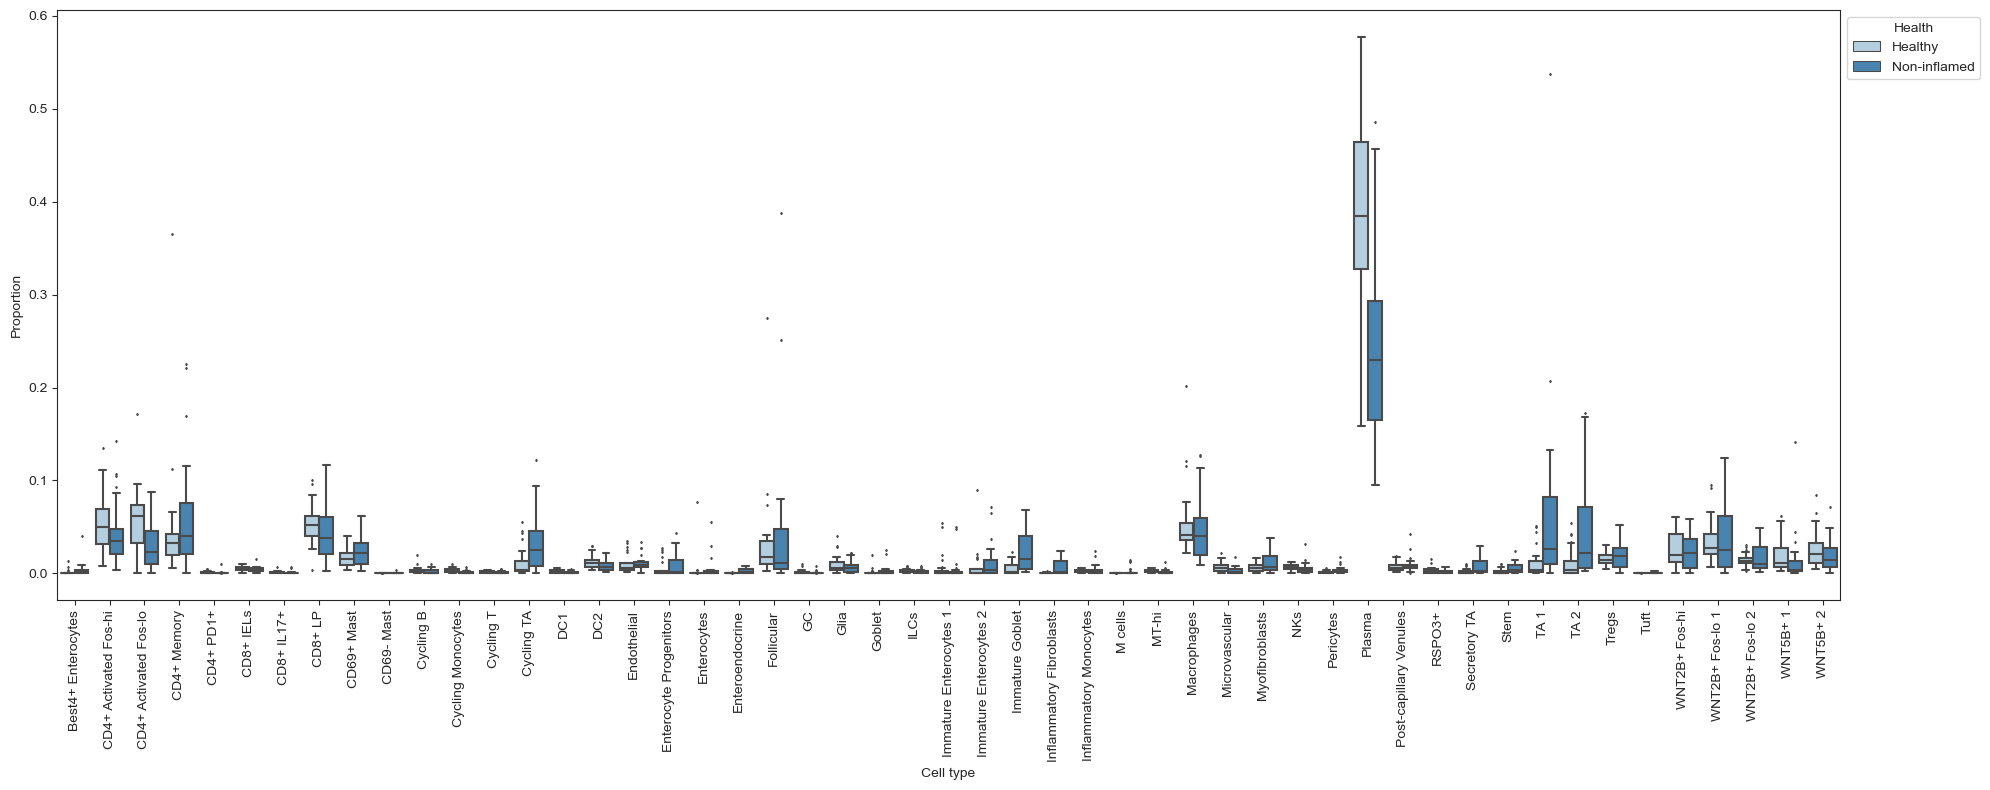

In [6]:
pt.pl.coda.boxplots(smillie_data, modality_key="coda_LP", feature_name="Health", figsize=(20, 8))
plt.show()

## Run tascCODA

Inferring credible effects with tascCODA on our data is now simply a matter of running the sampling process. The model creation and inference works analogous to scCODA (see the scCODA quickstart tutorial)

As hyperparameters, we have to specify in the `prepare` function:
- The reference cell type (which is assumed to be unchanged between the conditions): We use the `automatic` setting here, which chooses a reference that induces minimal compositional effects (here we use the automatic suggestion - NK cells)
- The model formula (R-style formula string, just as in scCODA)
- The aggregation bias $\phi$, defined in the [tascCODA paper](https://www.frontiersin.org/articles/10.3389/fgene.2021.766405/full). We go with an unbiased aggregation (`pen_args={"phi": 0}`) here.
- The key in `.uns` of our MuData modality where the tree is saved.

Then, we run No-U-turn sampling via `run_nuts` with the default settings of 11.000 samples, of which 1.000 are discarded as burn-in

In [7]:
smillie_data = tasccoda_model.prepare(smillie_data, modality_key="coda_LP", tree_key="tree", reference_cell_type="automatic", formula="Health", pen_args={"phi": 0})
smillie_data

Automatic reference selection! Reference cell type set to NKs

Zero counts encountered in data! Added a pseudocount of 0.5.

MuData object with n_obs × n_vars = 365625 × 51
  3 modalities
    rna:	365492 x 0
      obs:	'NAME', 'Subject', 'Sample', 'Location', 'Replicate', 'Health', 'Cluster', 'nGene', 'nUMI', 'Major_l1', 'Major_l2', 'Major_l3', 'Major_l4', 'scCODA_sample_id'
    coda:	133 x 51
      obs:	'Location', 'Health', 'Subject', 'Sample'
      var:	'n_cells'
      uns:	'tree'
    coda_LP:	48 x 51
      obs:	'Location', 'Health', 'Subject', 'Sample'
      var:	'n_cells'
      uns:	'tree', 'scCODA_params'
      obsm:	'covariate_matrix', 'sample_counts'

In [8]:
tasccoda_model.run_nuts(smillie_data, modality_key="coda_LP")

sample: 100%|██████████| 11000/11000 [05:37<00:00, 32.64it/s, 63 steps of size 7.53e-02. acc. prob=0.93]


## Result analysis

Calling `summary`, we can see the most relevant information for further analysis:



In [9]:
tasccoda_model.summary(smillie_data, modality_key="coda_LP")

                                          Compositional Analysis summary                                           
┌────────────────────────────────────────────┬────────────────────────────────────────────────────────────────────┐
│ Name                                       │ Value                                                              │
├────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────┤
│ Data                                       │ Data: 48 samples, 51 cell types                                    │
│ Reference cell type                        │ NKs                                                                │
│ Formula                                    │ Health                                                             │
└────────────────────────────────────────────┴────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                           Final Parameter  Expected Sample                                                      │
│ Cell Type                                                                                                       │
│ Best4+ Enterocytes            -1.183            10.338                                                          │
│ CD4+ Activated Fos-hi          1.562           160.905                                                          │
│ CD4+ Activated Fos-lo          1.609           168.648                                                          │
│ CD4+ Memory                    1.320           126.319                                                          │
│ CD4+ PD1+                     -0.932            13.287                                                          │
│ CD8+ IELs                     -0.112            30.169                                                          │
│ CD8+ IL17+                    -0.803            15.117                                                          │
│ CD8+ LP                        1.604           167.807                                                          │
│ CD69+ Mast                     0.593            61.057                                                          │
│ CD69- Mast                    -1.353             8.722                                                          │
│ Cycling B                     -0.480            20.880                                                          │
│ Cycling Monocytes             -0.565            19.179                                                          │
│ Cycling T                     -0.699            16.774                                                          │
│ Cycling TA                     0.092            36.996                                                          │
│ DC1                           -0.605            18.427                                                          │
│ DC2                            0.353            48.029                                                          │
│ Endothelial                    0.118            37.971                                                          │
│ Enterocyte Progenitors        -0.903            13.678                                                          │
│ Enterocytes                   -1.217             9.992                                                          │
│ Enteroendocrine               -1.265             9.524                                                          │
│ Follicular                     0.829            77.309                                                          │
│ GC                            -0.914            13.529                                                          │
│ Glia                          -0.105            30.381                                                          │
│ Goblet                        -1.217             9.992                                                          │
│ ILCs                          -0.845            14.495                                                          │
│ Immature Enterocytes 1        -1.067            11.609                                                          │
│ Immature Enterocytes 2        -0.823            14.818                                                          │
│ Immature Goblet               -0.329            24.284                                                          │
│ Inflammatory Fibroblasts      -0.972            12.766                                                          │
│ Inflammatory Monocytes        -0.537            19.724

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                Effect  Expected Sample  log2-fold change                        │
│ Covariate            Cell Type                                                                                  │
│ HealthT.Non-inflamed Best4+ Enterocytes         0.000      19.399             0.908                             │
│                      CD4+ Activated Fos-hi     -0.676     153.578            -0.067                             │
│                      CD4+ Activated Fos-lo     -1.035     112.416            -0.585                             │
│                      CD4+ Memory               -0.676     120.567            -0.067                             │
│                      CD4+ PD1+                 -0.676      12.682            -0.067                             │
│                      CD8+ IELs                 -0.676      28.795            -0.067                             │
│                      CD8+ IL17+                -0.676      14.429            -0.067                             │
│                      CD8+ LP                   -0.676     160.165            -0.067                             │
│                      CD69+ Mast                -0.263      88.077             0.529                             │
│                      CD69- Mast                -0.263      12.581             0.529                             │
│                      Cycling B                 -0.708      19.302            -0.113                             │
│                      Cycling Monocytes         -0.603      19.692             0.038                             │
│                      Cycling T                 -0.676      16.010            -0.067                             │
│                      Cycling TA                 0.000      69.422             0.908                             │
│                      DC1                       -0.603      18.920             0.038                             │
│                      DC2                       -0.603      49.314             0.038                             │
│                      Endothelial               -0.366      49.413             0.380                             │
│                      Enterocyte Progenitors     0.000      25.667             0.908                             │
│                      Enterocytes                0.000      18.750             0.908                             │
│                      Enteroendocrine            0.000      17.871             0.908                             │
│                      Follicular                -0.708      71.465            -0.113                             │
│                      GC                        -0.708      12.506            -0.113                             │
│                      Glia                      -0.366      39.536             0.380                             │
│                      Goblet                     0.000      18.750             0.908                             │
│                      ILCs                       0.000      27.200             0.908                             │
│                      Immature Enterocytes 1     0.000      21.785             0.908                             │
│                      Immature Enterocytes 2     0.000      27.805             0.908                             │
│                      Immature Goblet            0.000      45.568             0.908                             │
│                      Inflammatory Fibroblasts  -0.366      16.613             0.380                             │
│                      Inflammatory Monocytes    -0.603 

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Nodes                                                                                                           │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Covariate=Health[T.Non-inflamed]_node                                                                           │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                   Final Parameter  Is credible                                                  │
│ Node                                                                                                            │
│ Major_l1_Immune                        0.00           False                                                     │
│ Major_l2_Epithelial                    0.00           False                                                     │
│ Major_l2_Stromal                      -0.37            True                                                     │
│ Major_l2_Lymphoid                      0.00           False                                                     │
│ Major_l2_Myeloid                      -0.26            True                                                     │
│ Major_l3_Absorptive                    0.00           False                                                     │
│ Major_l3_Secretory                     0.00           False                                                     │
│ Cycling TA                             0.00           False                                                     │
│ Stem                                   0.00           False                                                     │
│ M cells                                0.00           False                                                     │
│ Major_l3_Fibroblasts                   0.00           False                                                     │
│ Major_l4_EndothelialCells              0.00           False                                                     │
│ Glia                                   0.00           False                                                     │
│ Major_l3_T cells                      -0.68            True                                                     │
│ Major_l3_B cells                      -0.71            True                                                     │
│ NKs                                    0.00           False                                                     │
│ ILCs                                   0.00           False                                                     │
│ Major_l3_Mast                          0.00           False                                                     │
│ Major_l3_Monocytes                    -0.34            True                                                     │
│ Major_l4_Immature cells                0.00           False                                                     │
│ Major_l4_TA cells                      0.34            True                                                     │
│ Major_l4_Absorptive Mature cells       0.00           False                                                     │
│ Major_l4_Progenitor cells              0.00           False                                                     │
│ Major_l4_Secretory Mature cells        0.00           False                                                     │
│ Major_l4_WNT5B+                        0.00           False                                                     │
│ Major_l4_WNT2B+                        0.00           False                                                     │
│ Inflammatory Fibroblasts               0.00           False                                                     │
│ Myofibroblasts                         0.00           

**Model properties**

First, the summary shows an overview over the model properties:
* Number of samples/cell types
* The reference cell type.
* The formula used

The model has three types of parameters that are relevant for analysis - intercepts, feature-level effects and node-wise effects.
These can be interpreted like in a standard regression model:
Intercepts show how the cell types are distributed without any active covariates, effects show how the covariates influence the cell types.

**Intercepts**

The first column of the intercept summary shows the parameters determined by the MCMC inference.

The "Expected sample" column gives some context to the numerical values.
If we had a new sample (with no active covariates) with a total number of cells equal to the mean sampling depth of the dataset,
then this distribution over the cell types would be most likely.

**Feature-level Effects**

For the feature-level effect summary, the first column again shows the inferred parameters for all combinations of covariates and cell types, as sums over node-level effects on all parent nodes.
Most important is the distinction between zero and non-zero entries
A value of zero means that no statistically credible effect was detected.
For a value other than zero, a credible change was detected. A positive sign indicates an increase, a negative sign a decrease in abundance.

Since the numerical values of the "Effect" column are not straightforward to interpret, the "Expected sample" and "log2-fold change" columns give us an idea on the magnitude of the change.
The expected sample is calculated for each covariate separately (covariate value = 1, all other covariates = 0), with the same method as for the intercepts.
The log-fold change is then calculated between this expected sample and the expected sample with no active covariates from the intercept section.
Since the data is compositional, cell types for which no credible change was detected, will still change in abundance as well, as soon as a credible effect is detected on another cell type due to the sum-to-one constraint.
If there are no credible effects for a covariate, its expected sample will be identical to the intercept sample, therefore the log2-fold change is 0.

**Node-level effects**

These parameters are the most important ones. They describe, at which points in the tree a credible change in abundance was detected. The data frame just has two columns:
The "Final Parameter" column shows the effect values, the "Is credible" column simply depicts whether the inferred effect is different from 0, i.e. credible.
In a normal tascCODA analysis, we are interested in which subtrees (i.e. nodes) have a nonzero effect, which we can easily extract:

In [10]:
tasccoda_model.credible_effects(smillie_data, modality_key="coda_LP")

Covariate                    Node                 
Health[T.Non-inflamed]_node  Major_l1_Immune          False
                             Major_l2_Epithelial      False
                             Major_l2_Stromal          True
                             Major_l2_Lymphoid        False
                             Major_l2_Myeloid          True
                                                      ...  
                             CD4+ Activated Fos-hi    False
                             MT-hi                    False
                             Tregs                    False
                             DC2                      False
                             DC1                      False
Name: Final Parameter, Length: 74, dtype: bool


**Interpretation**

We see that most credible effects are on intermediate nodes. The only slight increase in abundance is on TA cells, while there are decreases on Stromal and some Immune cell types.
The most important decreases (i.e. with the largest effect sizes) can be found on B- and T-cells.
Plasma cells have an additional decrease, meaning that they change even stronger in abundance than the rest of the B-cell lineage

We can also easily plot the credible effects as nodes on the tree for better visualization.

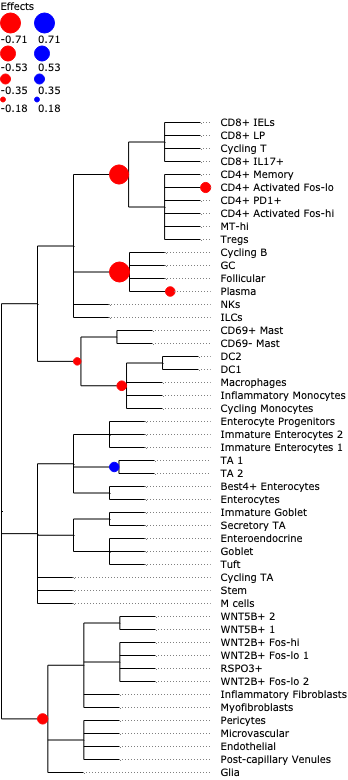

In [11]:
pt.pl.coda.draw_effects(smillie_data, modality_key="coda_LP", tree=smillie_data["coda_LP"].uns["tree"], covariate="Health[T.Non-inflamed]")

To better see the size of aggregated effects on the individual cell types, we can plot them at the side of the tree plot:

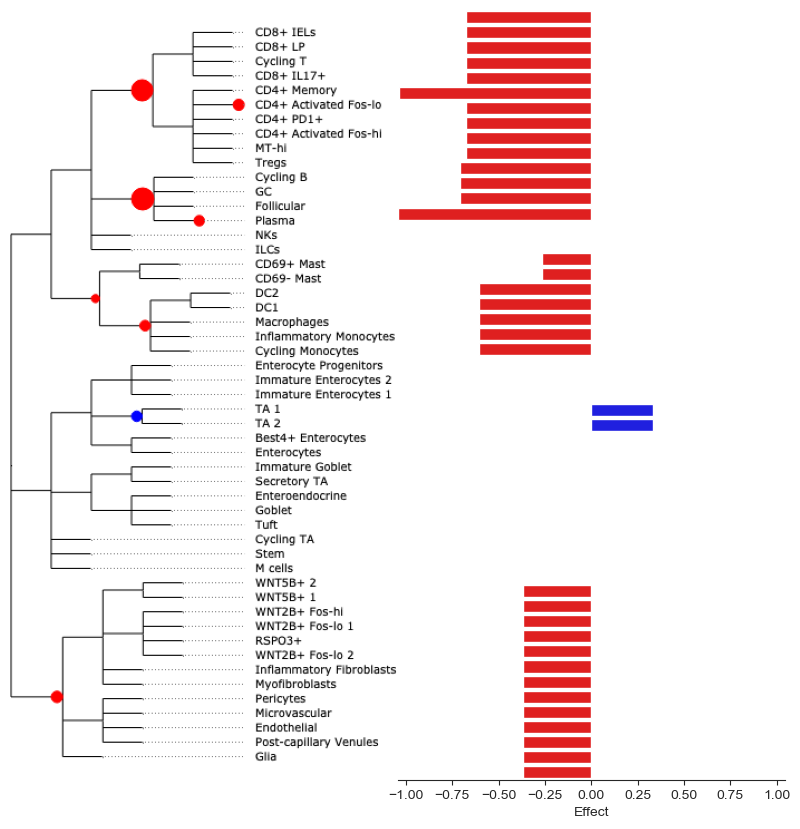

In [12]:
pt.pl.coda.draw_effects(smillie_data, modality_key="coda_LP", tree=smillie_data["coda_LP"].uns["tree"], covariate="Health[T.Non-inflamed]", show_legend=False, show_leaf_effects=True)
